<center>
    <h1> ILI-285 - Computación Científica I  </h1>
    <h2> Tarea 2 </h2>
    <h2> 11 de mayo de 2016</h2>
</center>

Integrantes: 
* Roberto Felipe Fuentes Zenteno - 201173037-2 - roberto.fuentes@alumnos.usm.cl 
* German Marcelo Treimun Costa - 201173085-2 - german.treimun@alumnos.usm.cl

## Tabla de contenidos
* [Introduccion](#intro)
* [Desarrollo y analisis de resultados](#desarrollo)
    - [Métodos iterativos](#seccion1)
    - [Implementando la simulación](#seccion2)
* [Conclusiones](#conclusion)
* [Referencias](#ref)

<div id='intro' />
<center>
    <h2> Introduccion </h2>
</center>

In [180]:
#Librerias y magics a usar para el laboratorio
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
%load_ext memory_profiler

ImportError: No module named 'memory_profiler'

<div id='desarrollo' />
<center>
    <h2> Desarrollo </h2>
</center>

<div id='seccion1' />

## 1 - Métodos iterativos



Funciones previas para el lab:

In [134]:
"""
Randomly generates an nxn strictly diagonally 
dominant matrix A.
"""
#funcion de matriz diagonal dominante
def diagonally_dominant(n, symmetric=False):
    A = np.random.random((n,n))
    deltas = 0.1*np.random.random(n)
    row_sum = A.sum(axis=1)-A.diagonal()
    np.fill_diagonal(A, row_sum+deltas)
    return A

def vector_b(n):
    b = np.ones(n)
    return b

In [135]:
#Funcion para calcular matrices triangulares superiores, que se usaran para funciones mas adelante
def solve_triangular(A, b, upper=True):
    n = b.shape[0]
    x = np.zeros_like(b)
    if upper==True:
        #perform back-substitution
        x[-1] = (1./A[-1,-1]) * b[-1]
        for i in range(n-2, -1, -1):
            x[i] = (1./A[i,i]) * (b[i] - np.sum(A[i,i+1:] * x[i+1:]))
    else:
        #perform forward-substitution
        x[0] = (1./A[0,0]) * b[0]
        for i in range(1,n):
            x[i] = (1./A[i,i]) * (b[i] - np.sum(A[i,:i] * x[:i]))
    return x

In [136]:
#Definimos una funcion de error:
def error(X, y):
    D = X-y
    err = np.linalg.norm(D, axis=1, ord=np.inf)
    return err

**1)**

Los metodos de jacobi, gauss_seidel y SOR se exponen mas abajo se presentan mas abajo:

In [137]:
#Para un numero de iteraciones por defecto de 50, aunque puede ser cambiado este parametro:
def jacobi(A, b, n_iter=50):
    n = A.shape[0]
    #array with solutions
    X = np.empty((n_iter, n))
    #initial guess
    X[0] = np.zeros(n)
    #submatrices
    D = np.diag(A)
    Dinv = D**-1
    R = A - np.diag(D) #R=(L+U)
    for i in range(1, n_iter):
        X[i] = Dinv*(b - np.dot(R, X[i-1]))
    return X

def gauss_seidel(A, b, n_iter=50):
    n = A.shape[0]
    #array with solutions
    X = np.empty((n_iter, n))
    #initial guess
    X[0] = np.zeros(n)
    #submatrices
    R = np.tril(A) #R=(L+D)
    U = A-R
    for i in range(1, n_iter):
        X[i] = solve_triangular(R, b-np.dot(U, X[i-1]), upper=False)
    return X

def sor(A, b, w=1.125, n_iter=100):
    n = A.shape[0]
    #array with solutions
    X = np.empty((n_iter, n))
    #initial guess
    X[0] = np.zeros(n)
    #submatrices
    R = np.tril(A) #R=(L+D)
    U = A-R
    for i in range(1, n_iter):
        X_i = solve_triangular(R, b-np.dot(U, X[i-1]), upper=False)
        X[i] = w*X_i + (1-w)*X[i-1]
    return X

**2)**

La complejidad para los 3 metodos iterativos anteriores es de $I\cdot n^2$, ya que en las 3 ecuaciones, tenemos la forma de $x_{i+1} = x_i + N\cdot r_n$, donde N es una matriz, o suma de matrices: 


Jacobi: $N = (D^{-1})$

Gauss-Seidel: $N = (D + L)^{-1}$

SOR: $N = (L + \frac{D}{\omega})^{-1}$

donde la complejidad de estas ecuaciones se resume a una multiplicacion de matriz-vector, lo cual tiene como complejidad $n^{2}$, y al hacerlo una cantidad I de veces (las cuales serian las iteraciones), llegamos finalmente a la ecuacion $I\cdot n^2$ dicha anteriormente. 

**3)**

Para encontrar un valor optimo de $\omega$ lo que debemos hacer es encontrar varios valores de omega en un intervalo fijo, probando con cada $\omega$ el mejor w posible (es decir, el $\omega$ que hara que este metodo converja en la menor cantidad de interaciones). La forma de implementarlo entonces seria la siguiente:

In [138]:
#Definimos un largo de subdiviones
n = 30
A = diagonally_dominant(n)
#Creamos un vector b de puros unos vectorizada
b = vector_b(n)
np_sol = np.linalg.solve(A,b)
#Creamos una lista para las soluciones del sor
sor_solutions = list()
#Iteramos sobre un cierto rango en omega, y agregamos las soluciones que nos da el metodo
#SOR para cada omega
for w in np.linspace(0., 2., n):
    sor_solutions.append(sor(A, b, w, n_iter=5)[-1])
np.asarray(sor_solutions)
#Calculamos el error entre la solucion real y la soluciones de la lista de soluciones por cada omega
sor_errors = error(sor_solutions, np_sol)
#Finalmente se extrae el indice del minimo error. y se busca en el intervalo usado este indice
err = np.argmin(sor_errors)
w=np.linspace(0., 2, n)[err]

Luego que tenemos una muestra de puntos para w, lo graficamos y vemos que sucede:

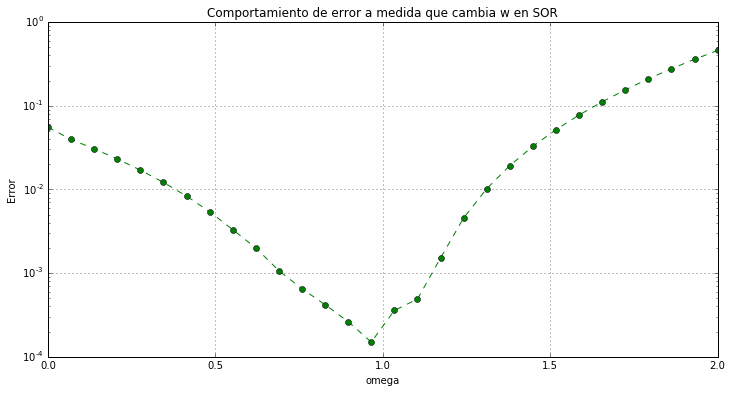

In [139]:
w = np.linspace(0., 2., n)
plt.figure(figsize=(12,6))
plt.semilogy(w, sor_errors, marker='o', linestyle='--', color='g')
plt.grid(True)
plt.xlabel('omega')
plt.ylabel('Error')
plt.title('Comportamiento de error a medida que cambia w en SOR')
plt.show()

Por lo cual vemos que despues de ciertas iteraciones el $\omega$ empieza a aumentar su error. Siendo asi, el $\omega$ que deberiamos escoger deberia estar el de menor error en la grafica (es decir, el que presente el menor error).

**4.1)** 

Primero, computamos los 3 metodos con los valores de $n = 10,100,1000$:

In [140]:
#Generamos una matriz aleatoria, con la condicion de que sea matriz diagonal dominante
n = 10
A = diagonally_dominant(n)
#Creamos un vector b de puros unos vectorizada
b = vector_b(n)
#Generamos 10 iteraciones
print ("Iteraciones para n = 10")
print ("A: ")
print (A)
print ("b")
print (b)
print ("Jacobi: ")
print (jacobi(A,b,10))
print ("Gauss-Seidel: ")
print (gauss_seidel(A,b,10))
print ("SOR: ")
print (sor(A,b,w=1.5,n_iter = 10))

Iteraciones para n = 10
A: 
[[  3.97578214e+00   5.27992515e-01   5.89071344e-01   2.59246025e-03
    7.89005557e-01   2.01402423e-01   5.07534619e-01   3.45728692e-01
    8.52859549e-01   8.67065094e-02]
 [  8.12975036e-01   4.67994169e+00   5.15443098e-01   4.49247102e-01
    3.51557535e-01   3.57744415e-01   1.96711152e-01   8.14324323e-01
    4.02845705e-01   7.53845944e-01]
 [  2.01591823e-02   1.18297719e-01   3.24444681e+00   7.33319576e-01
    6.75227615e-01   7.48551595e-02   1.68448987e-01   2.92273696e-02
    4.11482845e-01   9.39052052e-01]
 [  1.49887748e-01   9.96011334e-01   4.30158792e-01   5.05263666e+00
    1.49366380e-01   5.39347438e-01   3.21110063e-01   9.23265089e-01
    7.31206487e-01   7.30583011e-01]
 [  6.94990717e-01   7.33547229e-01   9.15751827e-01   9.44361897e-01
    4.97720070e+00   7.83736418e-01   1.98011261e-01   2.63732818e-01
    2.58861264e-01   1.62843288e-01]
 [  2.54189771e-01   4.81664363e-01   3.50830575e-01   5.36373143e-01
    9.01378247e-0

Luego, para $n = 100$:

In [141]:
#Generamos una matriz aleatoria, con la condicion de que sea matriz diagonal dominante
n = 100
A = diagonally_dominant(n)
#Creamos un vector b de puros unos vectorizada
b = vector_b(n)
#Generamos 100 iteraciones
print ("Iteraciones para n = 100")
print ("A: ")
print (A)
print ("b")
print (b)
print ("Jacobi: ")
print (jacobi(A,b,100))
print ("Gauss-Seidel: ")
print (gauss_seidel(A,b,100))
print ("SOR: ")
print (sor(A,b,w=1.5,n_iter = 100))

Iteraciones para n = 100
A: 
[[  5.35261937e+01   7.84702628e-01   3.60939874e-01 ...,   9.63138972e-01
    9.08238395e-02   5.71883238e-01]
 [  9.63596965e-01   5.33614923e+01   1.75638690e-02 ...,   6.20960048e-01
    4.95867728e-01   1.84774052e-01]
 [  8.50234900e-01   4.09252595e-01   4.46490941e+01 ...,   8.78576442e-02
    2.47033925e-01   9.53385232e-01]
 ..., 
 [  2.27094154e-01   5.50844938e-03   1.61238078e-01 ...,   4.76247340e+01
    3.78369937e-01   5.53729610e-01]
 [  6.07150346e-01   1.40883933e-01   9.01905472e-01 ...,   6.15025582e-01
    5.03580055e+01   4.99552657e-01]
 [  9.80092753e-02   1.54122110e-01   5.07518654e-01 ...,   5.99779972e-01
    6.16314394e-01   5.25193109e+01]]
b
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  

Finalmente para $n = 1000$:

In [142]:
#Generamos una matriz aleatoria, con la condicion de que sea matriz diagonal dominante
n = 1000
A = diagonally_dominant(n)
#Creamos un vector b de puros unos vectorizada
b = vector_b(n)
#Generamos 1000 iteraciones
print ("Iteraciones para n = 1000")
print ("A: ")
print (A)
print ("b")
print (b)
print ("Jacobi: ")
print (jacobi(A,b,1000))
print ("Gauss-Seidel: ")
print (gauss_seidel(A,b,1000))
print ("SOR: ")
print (sor(A,b,w=1.5,n_iter = 1000))

Iteraciones para n = 1000
A: 
[[  5.13189408e+02   3.65974923e-01   2.46253974e-01 ...,   8.85057183e-01
    2.58644639e-01   8.81114615e-01]
 [  9.31732198e-01   4.89937758e+02   2.25413427e-01 ...,   1.34617895e-01
    8.95560463e-01   3.58671406e-01]
 [  3.88772819e-01   6.01674118e-01   5.00538816e+02 ...,   5.16108822e-01
    8.19651829e-02   2.79159497e-01]
 ..., 
 [  9.14372839e-01   7.81984738e-01   1.83819824e-01 ...,   4.92317291e+02
    3.17180640e-01   3.64198379e-01]
 [  8.56449400e-01   8.75933252e-01   2.44468045e-01 ...,   1.55528517e-01
    5.00337437e+02   2.88226897e-02]
 [  2.86993895e-01   8.23900437e-01   1.64197766e-01 ...,   5.13362491e-01
    3.34725174e-01   4.92853938e+02]]
b
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 

**4.2)**

Realizamos el calculo para $n=10,100,1000$ del primer metodo jacobi. Para $n=10$:

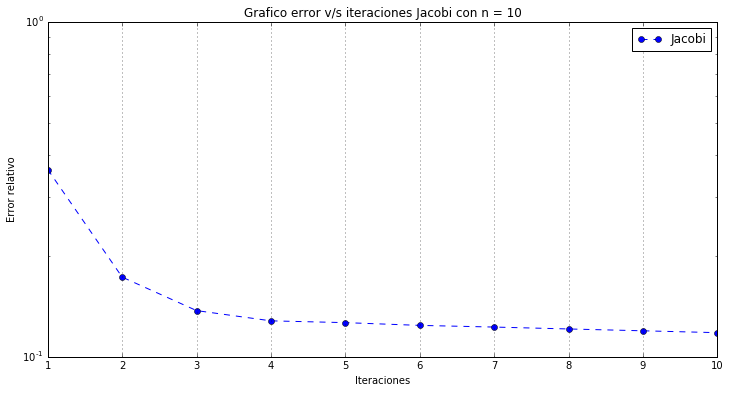

In [143]:
#Definimos n
n = 10

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Definimos los errores de cada metodo iterativo
#Error Jacobi
jac_sol = jacobi(A,b,n)
jac_err = error(jac_sol, np_sol)

it_1 = np.linspace(1, 10, num = 10)

#grafico de errores para n = 10
plt.figure(figsize=(12,6))
plt.semilogy(it_1, jac_err, marker='o', linestyle='--', color='b', label='Jacobi')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones Jacobi con n = 10')
plt.legend(loc=0)
plt.show()



Luego para jacobi con $n=100$ iteraciones:

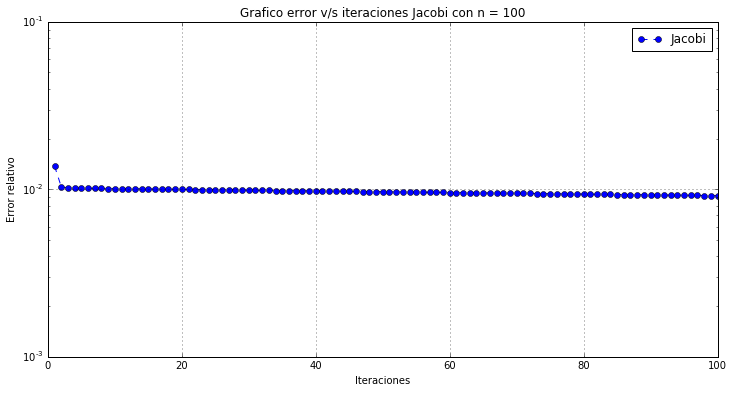

In [144]:
#Definimos n
n = 100

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Definimos los errores de cada metodo iterativo
#Error Jacobi
jac_sol = jacobi(A,b,n)
jac_err = error(jac_sol, np_sol)

it_2 = np.linspace(1, 100, num = 100)

#grafico de errores para n = 100
plt.figure(figsize=(12,6))
plt.semilogy(it_2, jac_err, marker='o', linestyle='--', color='b', label='Jacobi')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones Jacobi con n = 100')
plt.legend(loc=0)
plt.show()

Finalmente para $n=1000$:

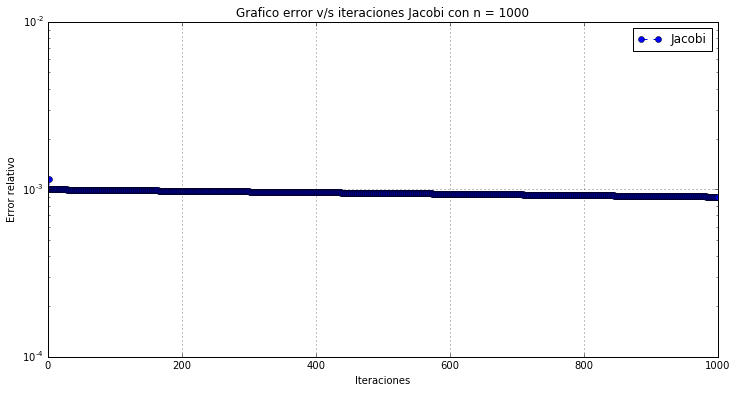

In [145]:
#Definimos n
n = 1000

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Definimos los errores de cada metodo iterativo
#Error Jacobi
jac_sol = jacobi(A,b,n)
jac_err = error(jac_sol, np_sol)

it_3 = np.linspace(1, 1000, num = 1000)

#grafico de errores para n = 1000
plt.figure(figsize=(12,6))
plt.semilogy(it_3, jac_err, marker='o', linestyle='--', color='b', label='Jacobi')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones Jacobi con n = 1000')
plt.legend(loc=0)
plt.show()

Luego repetimos los mismos $n$ para el metodo de Gauss-Seidel. Para $n=10$:

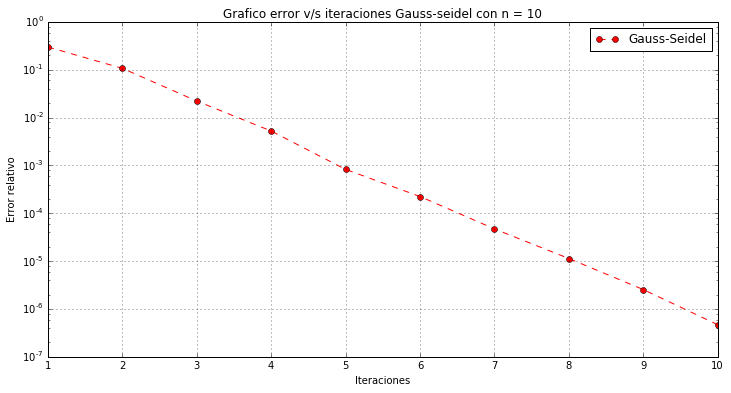

In [146]:
#Definimos n
n = 10

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error Gauss-Seidel
gauss_sol = gauss_seidel(A,b,n)
gauss_err = error(gauss_sol, np_sol)

#grafico de errores para n = 10
plt.figure(figsize=(12,6))
plt.semilogy(it_1, gauss_err, marker='o', linestyle='--', color='r', label='Gauss-Seidel')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones Gauss-seidel con n = 10')
plt.legend(loc=0)
plt.show()

Luego para $n = 100$

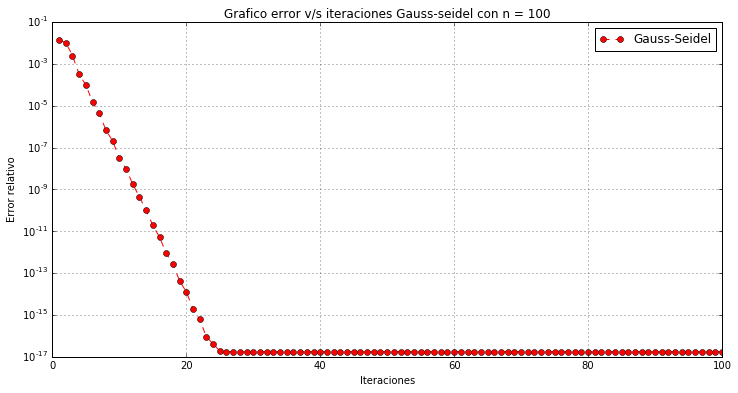

In [147]:
#Definimos n
n = 100

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error Gauss-Seidel
gauss_sol = gauss_seidel(A,b,n)
gauss_err = error(gauss_sol, np_sol)

#grafico de errores para n = 100
plt.figure(figsize=(12,6))
plt.semilogy(it_2, gauss_err, marker='o', linestyle='--', color='r', label='Gauss-Seidel')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones Gauss-seidel con n = 100')
plt.legend(loc=0)
plt.show()

Finalmente para $n=1000$:

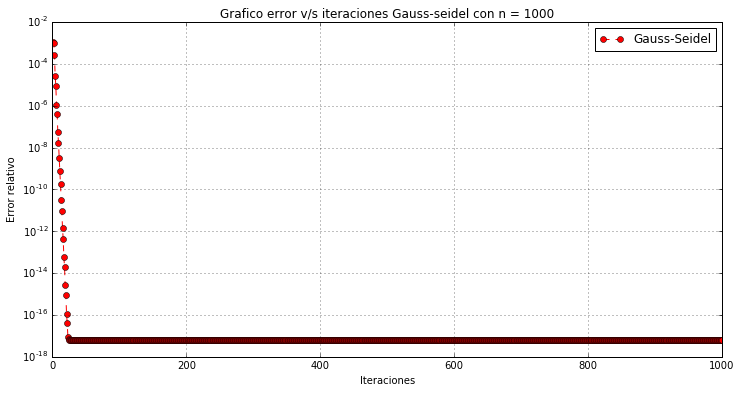

In [148]:
#Definimos n
n = 1000

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error Gauss-Seidel
gauss_sol = gauss_seidel(A,b,n)
gauss_err = error(gauss_sol, np_sol)

#grafico de errores para n = 1000
plt.figure(figsize=(12,6))
plt.semilogy(it_3, gauss_err, marker='o', linestyle='--', color='r', label='Gauss-Seidel')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones Gauss-seidel con n = 1000')
plt.legend(loc=0)
plt.show()

Finalmente terminamos con el metodo SOR para los 3 $n$. Para $n = 10$:

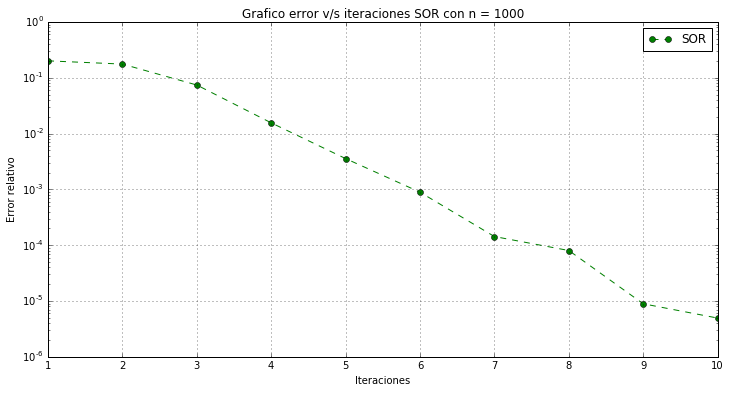

In [149]:
#Definimos n
n = 10

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error SOR
sor_sol = sor(A, b, w=1.15, n_iter=n)
sor_err = error(sor_sol, np_sol)

#grafico de errores para n = 10
plt.figure(figsize=(12,6))
plt.semilogy(it_1, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones SOR con n = 1000')
plt.legend(loc=0)
plt.show()

Luego para $n=100$:

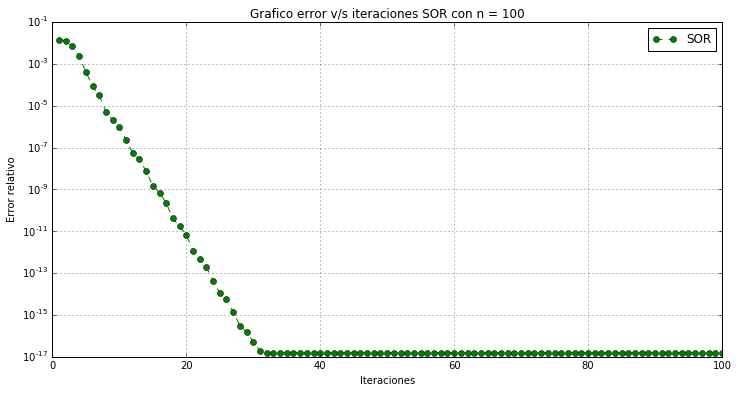

In [150]:
#Definimos n
n = 100

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error SOR
sor_sol = sor(A, b, w=1.15, n_iter=n)
sor_err = error(sor_sol, np_sol)

#grafico de errores para n = 100
plt.figure(figsize=(12,6))
plt.semilogy(it_2, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones SOR con n = 100')
plt.legend(loc=0)
plt.show()

Finalmente para $n = 1000$:

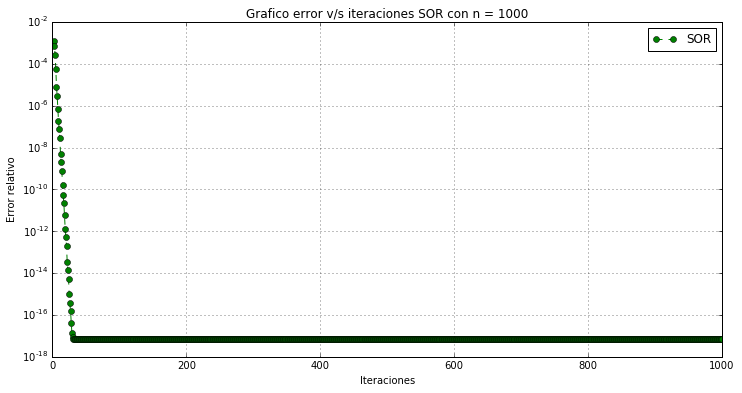

In [151]:
#Definimos n
n = 1000

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error SOR
sor_sol = sor(A, b, w=1.15, n_iter=n)
sor_err = error(sor_sol, np_sol)

#grafico de errores para n = 1000
plt.figure(figsize=(12,6))
plt.semilogy(it_3, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones SOR con n = 1000')
plt.legend(loc=0)
plt.show()

De aqui podemos concluir que a medida que se realizan mas iteraciones, mas pequeño es el error y por lo tanto la respuesta es mas acertada para los metodos de Gauss-seidel y SOR. Para el caso de Jacobi, vemos que a pesar de que el error disminuye a cada iteracion, el error baja muy lento en comparacion a los otros 2 metodos, por lo que habria que realizar mas iteraciones para acercarse mas a la iteracion.

**4.3)**

Luego, realizamos el grafico comparativos de errores relativos vs numero de iteraciones para los 3 metodos en cada $n$. para $n = 10$, tenemos que:

In [152]:
#Definimos n
n = 10

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Definimos los errores de cada metodo iterativo
#Error Jacobi
jac_sol = jacobi(A,b,n)
jac_err = error(jac_sol, np_sol)

#Error Gauss-Seidel
gauss_sol = gauss_seidel(A,b,n)
gauss_err = error(gauss_sol, np_sol)

#Error SOR
sor_sol = sor(A, b, w=1.15, n_iter=n)
sor_err = error(sor_sol, np_sol)

it_1 = np.linspace(1, 10, num = 10)

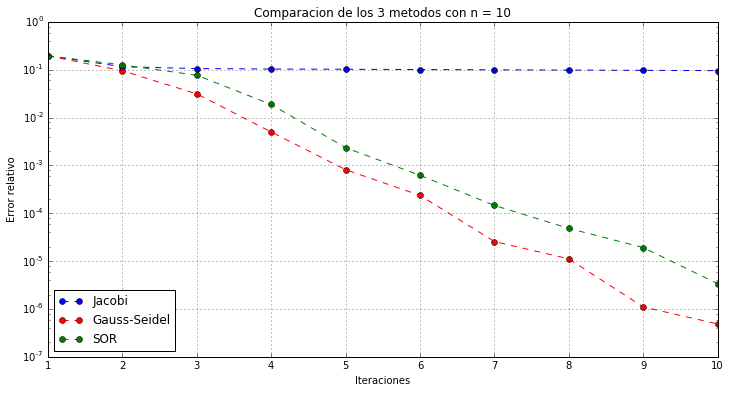

In [153]:
#grafico de errores para n = 10
plt.figure(figsize=(12,6))
plt.semilogy(it_1, jac_err, marker='o', linestyle='--', color='b', label='Jacobi')
plt.semilogy(it_1, gauss_err, marker='o', linestyle='--', color='r', label='Gauss-Seidel')
plt.semilogy(it_1, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Comparacion de los 3 metodos con n = 10')
plt.legend(loc=0)
plt.show()

Luego para $n = 100$:

In [154]:
n = 100

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Definimos los errores de cada metodo iterativo
#Error Jacobi
jac_sol = jacobi(A,b,n)
jac_err = error(jac_sol, np_sol)

#Error Gauss-Seidel
gauss_sol = gauss_seidel(A,b,n)
gauss_err = error(gauss_sol, np_sol)

#Error SOR
sor_sol = sor(A, b, w=1.15, n_iter=n)
sor_err = error(sor_sol, np_sol)

it_2 = np.linspace(1, 100, num = 100)

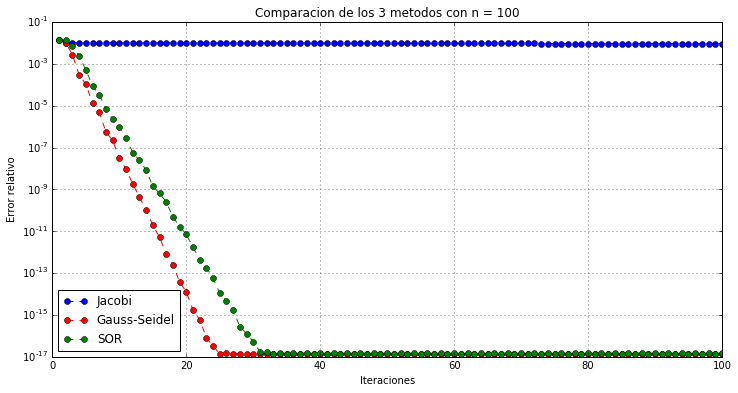

In [155]:
#grafico de errores para n = 100
plt.figure(figsize=(12,6))
plt.semilogy(it_2, jac_err, marker='o', linestyle='--', color='b', label='Jacobi')
plt.semilogy(it_2, gauss_err, marker='o', linestyle='--', color='r', label='Gauss-Seidel')
plt.semilogy(it_2, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Comparacion de los 3 metodos con n = 100')
plt.legend(loc=0)
plt.show()

Finalmente para $n = 1000$:

In [156]:
n = 1000

A = diagonally_dominant(n)

#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Definimos los errores de cada metodo iterativo
#Error Jacobi
jac_sol = jacobi(A,b,n)
jac_err = error(jac_sol, np_sol)

#Error Gauss-Seidel
gauss_sol = gauss_seidel(A,b,n)
gauss_err = error(gauss_sol, np_sol)

#Error SOR
sor_sol = sor(A, b, w=1.15, n_iter=n)
sor_err = error(sor_sol, np_sol)

it_3 = np.linspace(1, 1000, num = 1000)

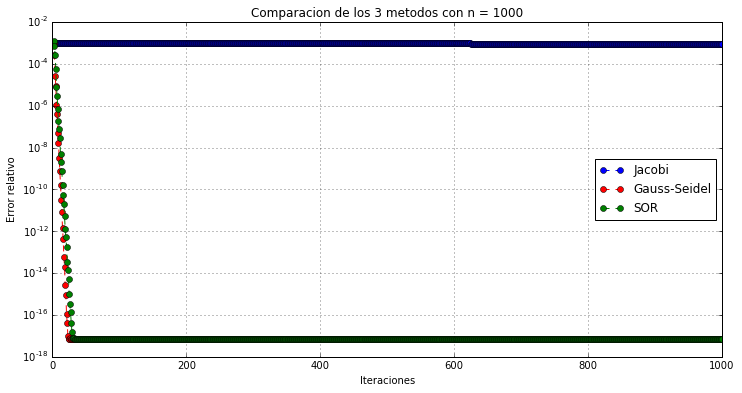

In [157]:
#grafico de errores para n = 1000
plt.figure(figsize=(12,6))
plt.semilogy(it_3, jac_err, marker='o', linestyle='--', color='b', label='Jacobi')
plt.semilogy(it_3, gauss_err, marker='o', linestyle='--', color='r', label='Gauss-Seidel')
plt.semilogy(it_3, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Comparacion de los 3 metodos con n = 1000')
plt.legend(loc=0)
plt.show()

En conclusion, observamos que al comparar los 3 graficos, el error en los 2 ultimos metodos se acerca bastante a la solucion real, y ademas converge al mismo valor despues de pocas iteraciones (es decir, llega al resultado en pocas interaciones). Por otro lado, Jacobi a pesar de tener un error pequeño, necesita de muchas iteraciones para poder reducir el error con respecto a la respuesta real.

**4.4)** 

Debemos sacar el minimo de todos los $\omega$ que existen, y Luego hacer las comparaciones con este $\omega$. Para $n=10$ nos queda: 

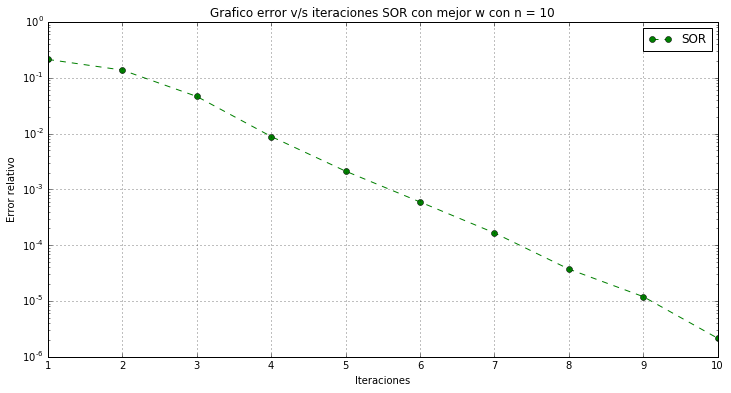

In [158]:
#Buscamos el error mas pequeño, y este indice lo buscamos en toda la data de w que pusimos, extrañendo asi el minimo w para que
#SOR converja mas rapido.
#Definimos un largo de subdiviones
n = 10
A = diagonally_dominant(n)
#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

np_sol = np.linalg.solve(A,b)
#Creamos una lista para las soluciones del sor
sor_solutions = list()
#Iteramos sobre un cierto rango en omega, y agregamos las soluciones que nos da el metodo
#SOR para cada omega
for w in np.linspace(0., 2., n):
    sor_solutions.append(sor(A, b, w, n_iter=5)[-1])
np.asarray(sor_solutions)
#Calculamos el error entre la solucion real y la soluciones de la lista de soluciones por cada omega
sor_errors = error(sor_solutions, np_sol)
#Finalmente se extrae el indice del minimo error. y se busca en el intervalo usado este indice
err = np.argmin(sor_errors)
w=np.linspace(0., 2, n)[err]

#Sacamos la solucion real
np_sol = np.linalg.solve(A,b)

#Error SOR
sor_sol = sor(A, b, w, n_iter=n)

sor_err = error(sor_sol, np_sol)

#grafico de errores para n = 10
plt.figure(figsize=(12,6))
plt.semilogy(it_1, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones SOR con mejor w con n = 10')
plt.legend(loc=0)
plt.show()


Luego, para $n = 100$:

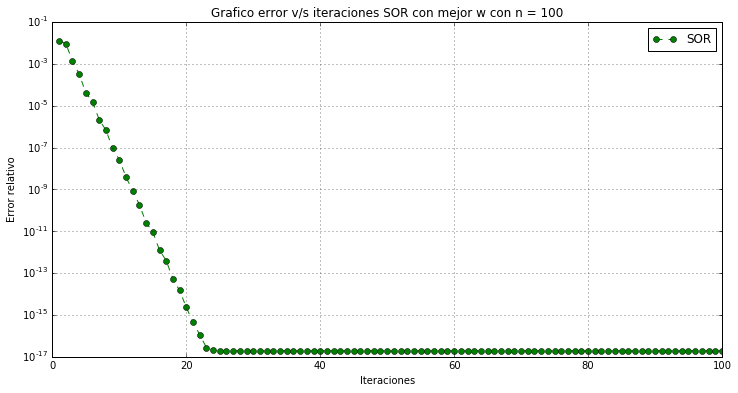

In [159]:
#Definimos un largo de subdiviones
n = 100
A = diagonally_dominant(n)
#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

np_sol = np.linalg.solve(A,b)
#Creamos una lista para las soluciones del sor
sor_solutions = list()
#Iteramos sobre un cierto rango en omega, y agregamos las soluciones que nos da el metodo
#SOR para cada omega
for w in np.linspace(0., 2., n):
    sor_solutions.append(sor(A, b, w, n_iter=5)[-1])
np.asarray(sor_solutions)
#Calculamos el error entre la solucion real y la soluciones de la lista de soluciones por cada omega
sor_errors = error(sor_solutions, np_sol)
#Finalmente se extrae el indice del minimo error. y se busca en el intervalo usado este indice
err = np.argmin(sor_errors)
w=np.linspace(0., 2, n)[err]

#Sacamos la solucion real
np_sol = np.linalg.solve(A,b)

#Error SOR
sor_sol = sor(A, b, w, n_iter=n)

sor_err = error(sor_sol, np_sol)

#grafico de errores para n = 10
plt.figure(figsize=(12,6))
plt.semilogy(it_2, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones SOR con mejor w con n = 100')
plt.legend(loc=0)
plt.show()

Finalmente para $n = 1000$:

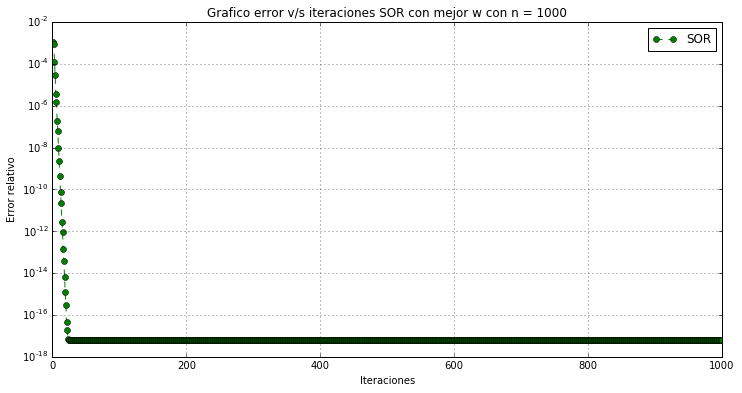

In [160]:
#Definimos un largo de subdiviones
n = 1000
A = diagonally_dominant(n)
#Creamos un vector b de puros unos vectorizada
b = vector_b(n)

np_sol = np.linalg.solve(A,b)
#Creamos una lista para las soluciones del sor
sor_solutions = list()
#Iteramos sobre un cierto rango en omega, y agregamos las soluciones que nos da el metodo
#SOR para cada omega
for w in np.linspace(0., 2., n):
    sor_solutions.append(sor(A, b, w, n_iter=5)[-1])
np.asarray(sor_solutions)
#Calculamos el error entre la solucion real y la soluciones de la lista de soluciones por cada omega
sor_errors = error(sor_solutions, np_sol)
#Finalmente se extrae el indice del minimo error. y se busca en el intervalo usado este indice
err = np.argmin(sor_errors)
w=np.linspace(0., 2, n)[err]

#Sacamos la solucion real
np_sol = np.linalg.solve(A,b)

#Error SOR
sor_sol = sor(A, b, w, n_iter=n)

sor_err = error(sor_sol, np_sol)

#grafico de errores para n = 10
plt.figure(figsize=(12,6))
plt.semilogy(it_3, sor_err, marker='o', linestyle='--', color='g', label='SOR')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones SOR con mejor w con n = 1000')
plt.legend(loc=0)
plt.show()

**5)**

Calculamos el timeit y el memit de cada uno de los casos. Para $n = 10$:

In [161]:
n = 10
A = diagonally_dominant(n)
b = vector_b(n)
%timeit jacobi(A, b)
%timeit gauss_seidel(A, b)
%timeit sor(A, b,w = 1.15)

%memit jacobi(A,b)
%memit gauss_seidel(A,b)
%memit sor(A,b)

The slowest run took 6.16 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 130 µs per loop
100 loops, best of 3: 2.37 ms per loop
100 loops, best of 3: 5.21 ms per loop


ERROR: Line magic function `%memit` not found.
ERROR: Line magic function `%memit` not found.
ERROR: Line magic function `%memit` not found.


Para $n = 100$:

In [162]:
n = 100
A = diagonally_dominant(n)
b = vector_b(n)
%timeit jacobi(A, b)
%timeit gauss_seidel(A, b)
%timeit sor(A, b,w = 1.15)

%memit jacobi(A,b)
%memit gauss_seidel(A,b)
%memit sor(A,b)

1000 loops, best of 3: 261 µs per loop
10 loops, best of 3: 21 ms per loop
10 loops, best of 3: 42.3 ms per loop


ERROR: Line magic function `%memit` not found.
ERROR: Line magic function `%memit` not found.
ERROR: Line magic function `%memit` not found.


Finalmente para $n = 1000$:

In [163]:
n = 1000
A = diagonally_dominant(n)
b = vector_b(n)
%timeit jacobi(A, b)
%timeit gauss_seidel(A, b)
%timeit sor(A, b,w = 1.15)

%memit jacobi(A,b)
%memit gauss_seidel(A,b)
%memit sor(A,b)

10 loops, best of 3: 28.1 ms per loop
1 loop, best of 3: 292 ms per loop
1 loop, best of 3: 641 ms per loop


ERROR: Line magic function `%memit` not found.
ERROR: Line magic function `%memit` not found.
ERROR: Line magic function `%memit` not found.


**6)** 

El algoritmo que se usa para calcular el gradiente conjugado es el siguiente:

In [164]:
def conjugate_gradient(A, b):
    #Definimos los elementos principales para el gradiente conjugado, es decir un vector inicial, un vector direccion
    #y un vector residuo. Ademas, se instancian estos vectores
    n = A.shape[0]
    x_0 = np.zeros(n)
    X = np.empty((n, n))
    d = b - np.dot(A, x_0)
    R = np.empty((n, n))
    X[0] = x_0
    R[0] = b - np.dot(A, x_0)

    for k in range(1, n):
        #Si el algoritmo converge, se detiene
        if (all( v == 0 for v in R[k-1]) and pr): 
            X[k:] = X[k-1]
            return X
        #Calculamos 5 pasos del gradiente conjugado, los cuales son alpha, x_i+1, r_i+1, beta y d_i+1
            break
        alpha = np.dot(np.transpose(R[k-1]), R[k-1]) / np.dot(np.transpose(d), np.dot(A, d))
        X[k] = X[k-1] + alpha*d
        R[k] = R[k-1] - alpha*np.dot(A, d)
        beta = np.dot(np.transpose(R[k]), R[k])/np.dot(np.transpose(R[k-1]), R[k-1])
        d = R[k] + beta*d

    return X

**7)** 

La complejidad de este algoritmo es de $n^{3}$, ya que la operacion mas compleja recae en calcular el $\alpha$ del algoritmo, ya que tenemos un producto entre vector matriz, lo que nos queda un vector (y la complejidad de resolver esto es de $n^{2}$). Este producto hay que multiplicarlo por un vector, lo cual nos queda un escalar. Al hacer esta operacion, nos quedaria $n \cdot n^{2}$, lo que nos queda $n^{3}$ como su complejidad final.  

**8)** 

La implementacion del PALU seria la siguiente:

In [165]:
#Se crea una funcion para la permutacion de las filas i y j, de la matriz A
def row_perm(A, i, j):
    tmp = np.copy(A[i])
    A[i] = A[j]
    A[j] = tmp

#Luego se procede a descomponer la matriz A en las 3 matrices necesarias P,L,U
def palu_decomp(A, show=False):
    N,_ = A.shape
    #Al comienzo P es diagonal
    P = np.identity(N)
    #Al comienzo L es una matriz de 0
    L = np.zeros((N,N))
    #Al comienzo U es la matriz A
    U = np.copy(A)
    if show:
        print('Initial matrices')
        print('P = '); print(np.array_str(P, precision=2, suppress_small=True))
        print('L = '); print(np.array_str(L, precision=2, suppress_small=True))
        print('U = '); print(np.array_str(U, precision=2, suppress_small=True))
        print('----------------------------------------')
    #Se va iterandi porlas columnas
    for j in range(N-1):
        #Se calcula el nuevo pivote
        p_index = np.argmax(np.abs(U[j:,j]))
        if p_index != 0:
            row_perm(P, j, j+p_index)
            row_perm(U, j, j+p_index)
            row_perm(L, j, j+p_index)
        #Se itera sobre las filas
        for i in range(j+1,N):
            L[i,j] = U[i,j]/U[j,j]
            U[i] -= L[i,j]*U[j]
    np.fill_diagonal(L,1)
    return P,L,U

#Una vez descompuesta la matriz, se procede a resolver el problema Ax = b
def solve_palu(A, b, show=False):
    P,L,U = palu_decomp(A, show)
    #A.x = b -> P.A.x = P.b = b'
    b = np.dot(P,b)
    # L.c = b' with c = U.x
    c = solve_triangular(L, b, upper=False)
    x = solve_triangular(U, c)
    return x

**9)** 

La complejidad del metodo $PA=LU$ es $\frac{2}{3} \cdot n^{3}$.Para esto, descomponemos la matriz $A$ en 3 matrices $P, L$ y $U$ para luego resolver la ecuacion matricial $Ax = b$, ya que al hacer esto, la ecuacion nos queda como $P \cdot A = P\cdot b$, y como sabemos que $PA = LU$, la ecuacon queda como $L\cdot U = b'$, donde $b' = P\cdot b$. Luego, haciendo $Lc = b'$, y sacando los valores de c para poder despejar $Ux = c$. resolver estas ecuaciones se logra con BS y FS, que tienen complejidad $n^{2}$, lo cual se ve opacado al momento de separar la matriz $A$ en 3, ya que aqui se ocupa la eliminacion gausiana para hacerlo, algoritmo que tiene como complejidad $\frac{2}{3} \cdot n^{3}$:


**10)** 

Vemos para gradiente conjugado los $n = 10,100,1000$. Para $n = 10$: 

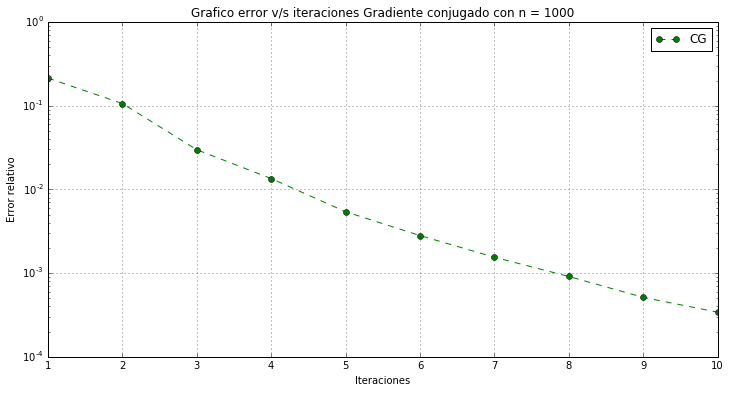

In [166]:
#Definimos n
n = 10

A = diagonally_dominant(n)
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error gradiente conjugado
con_sol = conjugate_gradient(A,b)
con_err = error(con_sol, np_sol)

#grafico de errores para n = 10
plt.figure(figsize=(12,6))
plt.semilogy(it_1, con_err, marker='o', linestyle='--', color='g', label='CG')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones Gradiente conjugado con n = 1000')
plt.legend(loc=0)
plt.show()

Para $n = 100$:

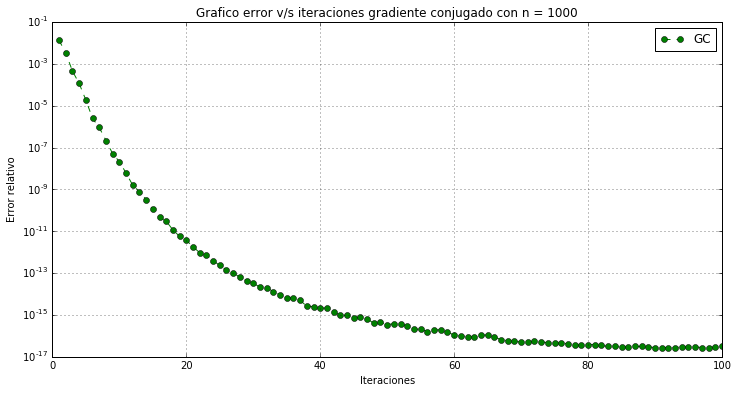

In [167]:
#Definimos n
n = 100

A = diagonally_dominant(n)
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error gradiente conjugado
con_sol = conjugate_gradient(A,b)
con_err = error(con_sol, np_sol)

#grafico de errores para n = 100
plt.figure(figsize=(12,6))
plt.semilogy(it_2, con_err, marker='o', linestyle='--', color='g', label='GC')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones gradiente conjugado con n = 1000')
plt.legend(loc=0)
plt.show()

Finalmente para $n = 1000$:

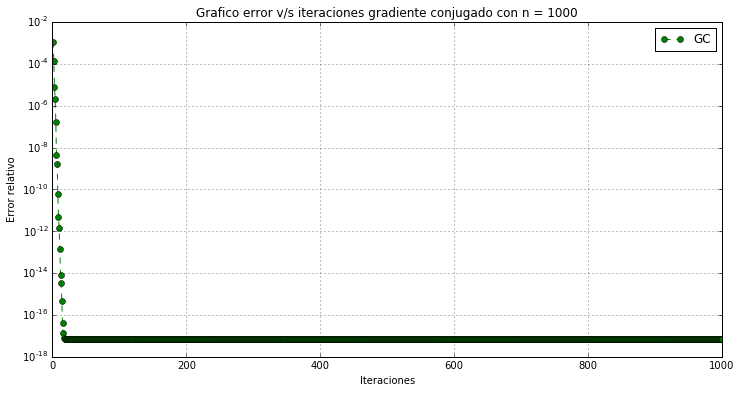

In [168]:
#Definimos n
n = 1000

A = diagonally_dominant(n)
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error gradiente conjugado
con_sol = conjugate_gradient(A,b)
con_err = error(con_sol, np_sol)

#grafico de errores para n = 1000
plt.figure(figsize=(12,6))
plt.semilogy(it_3, con_err, marker='o', linestyle='--', color='g', label='GC')
plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('Error relativo')
plt.title('Grafico error v/s iteraciones gradiente conjugado con n = 1000')
plt.legend(loc=0)
plt.show()

Para la factorizacion $PA=LU$ no se puede calcular errores a travez de las iteraciones, ya que es un metodo directo, por lo tanto el error solo sera uno, por lo tanto calcularemos solo un error para los 3 $n$ pedidos (No graficaremos los errores ya que no tiene sentido graficar un solo valor). Para $n = 10$ tenemos que:

In [169]:
#Definimos n
n = 10

A = diagonally_dominant(n)
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error PALU
palu_sol = solve_palu(A,b)
print (np.linalg.norm(palu_sol - np_sol))

8.00232282846e-17


Luego para $n=100$:

In [170]:
#Definimos n
n = 100

A = diagonally_dominant(n)
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error PALU
palu_sol = solve_palu(A,b)
print (np.linalg.norm(palu_sol - np_sol))

6.86258010309e-17


Finalmente para $n = 1000$:

In [171]:
#Definimos n
n = 1000

A = diagonally_dominant(n)
b = vector_b(n)

#Primero obtenemos la solucion real del sistema Ax = b
np_sol = np.linalg.solve(A,b)

#Error PALU
palu_sol = solve_palu(A,b)
print (np.linalg.norm(palu_sol - np_sol))

6.90865670894e-17


Observamos que en estos dos ultimos 2 metodos, se converge de forma muy rapida, ademas de que el error es muy bajo
(sobretodo en el metodo $PA=LU$). Finalmente vemos los timeit y memit de cada proceso. Para $n = 10$:

In [172]:
n = 10
A = diagonally_dominant(n)
b = vector_b(n)
%timeit conjugate_gradient(A, b)
%timeit solve_palu(A, b)

%memit conjugate_gradient(A,b)
%memit solve_palu(A,b)

The slowest run took 6.75 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 144 µs per loop
1000 loops, best of 3: 310 µs per loop


ERROR: Line magic function `%memit` not found.
ERROR: Line magic function `%memit` not found.


Para $n = 100$

In [173]:
n = 100
A = diagonally_dominant(n)
b = vector_b(n)
%timeit conjugate_gradient(A, b)
%timeit solve_palu(A, b)

%memit conjugate_gradient(A,b)
%memit solve_palu(A,b)

The slowest run took 4.36 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.45 ms per loop
10 loops, best of 3: 20.8 ms per loop


ERROR: Line magic function `%memit` not found.
ERROR: Line magic function `%memit` not found.


Para $n = 1000$

In [174]:
n = 1000
A = diagonally_dominant(n)
b = vector_b(n)
%timeit conjugate_gradient(A, b)
%timeit solve_palu(A, b)

%memit conjugate_gradient(A,b)
%memit solve_palu(A,b)

1 loop, best of 3: 1.31 s per loop
1 loop, best of 3: 2.77 s per loop


ERROR: Line magic function `%memit` not found.
ERROR: Line magic function `%memit` not found.


In [175]:
class Func():
    def __init__(self):
        self.sigma = 10.
        self.rho = 28.
        self.beta = 8./3
        self.h = 0.01
        self.x_prev = 0.
        self.y_prev = 0.
        self.z_prev = 0.
    
    def set_prev(self, X):
        self.x_prev, self.y_prev, self.z_prev = X
        
    def F(self, X):
        x, y, z = X
        #for readability
        x_prev, y_prev, z_prev = self.x_prev, self.y_prev, self.z_prev
        sigma, rho, beta = self.sigma, self.rho, self.beta
        h = self.h
        #En las ecuaciones, basta con pasar restando los hf_i, y dejarkas como F_i = 0
        f1 = x-x_prev-h*(sigma*(y-x))
        f2 = y-y_prev-h*(x*(rho-z)-y)
        f3 = z-z_prev-h*(x*y - beta*z)
        return np.array([f1,f2,f3])

    def DF(self, X):
        x, y, z = X
        #for readability
        x_prev, y_prev, z_prev = self.x_prev, self.y_prev, self.z_prev
        sigma, rho, beta = self.sigma, self.rho, self.beta
        h = self.h
        #Al ser 3 ecuaciones quedara una matriz de 3 x 3. Se calcula cada elemento de la matriz
        f1_x=1+h*sigma
        f1_y=-h*sigma
        f1_z=0
        f2_x=h*z-h*rho
        f2_y=1+h
        f2_z=x*h
        f3_x=-h*y
        f3_y=-h*x
        f3_z=1+h*(beta)
        return np.array([[f1_x, f1_y, f1_z],
                         [f2_x, f2_y, f2_z],
                         [f3_x, f3_y, f3_z]])

<div id='seccion2' />

## 2 - Implementando la simulación

In [ ]:
#Funciones de jacobi, gauss-seidel y sor para poder usarlas en el metodo de newton
def jacobi(A, b, n_iter=100):
    n = A.shape[0]
    #array with solutions
    X = np.empty((n_iter, n))
    #initial guess
    X[0] = np.zeros(n)
    #submatrices
    D = np.diag(A)
    Dinv = D**-1
    R = A - np.diag(D) #R=(L+U)
    for i in range(1, n_iter):
        X[i] = Dinv*(b - np.dot(R, X[i-1]))
    return X[-1]

def gauss_seidel(A, b, n_iter=100):
    n = A.shape[0]
    #array with solutions
    X = np.empty((n_iter, n))
    #initial guess
    X[0] = np.zeros(n)
    #submatrices
    R = np.tril(A) #R=(L+D)
    U = A-R
    for i in range(1, n_iter):
        X[i] = solve_triangular(R, b-np.dot(U, X[i-1]), upper=False)
    return X[-1]
def sor(A, b, w=1.125, n_iter=100):
    n = A.shape[0]
    #array with solutions
    X = np.empty((n_iter, n))
    #initial guess
    X[0] = np.zeros(n)
    #submatrices
    R = np.tril(A) #R=(L+D)
    U = A-R
    for i in range(1, n_iter):
        X_i = solve_triangular(R, b-np.dot(U, X[i-1]), upper=False)
        X[i] = w*X_i + (1-w)*X[i-1]
    return X[-1]

**1)** 

Aqui solo basta con pasar restando hacia el otro lado las ecuaciones , dejando $F_i = 0$ . Esto se muestra en el codigo de F() de mas arriba.
$x_{k+1} - xk + hf1(x_{k+1}, y_{k+1}, z_{k+1}) = 0 = F_1\\
y_{k+1} - yk + hf2(x_{k+1}, y_{k+1}, z_{k+1}) = 0 = F_2\\ 
z_{k+1} - zk + hf3(x_{k+1}, y_{k+1}, z_{k+1}) = 0 = F_3$

**2)** 

El calculo del Jacobiano se encuentra en la funcion DF() de la clase anterior.


$ \\ \frac{dF1}{dx} = 1 + h\cdot \sigma \\
\frac{dF1}{dy} =-h\cdot \sigma \\
\frac{dF1}{dz} = 0 \\
\frac{dF2}{dx} = h\cdot z - h\cdot \rho \\
\frac{dF2}{dy} = 1 + h \\
\frac{dF2}{dz} = x \cdot h \\
\frac{dF3}{dx} = -h \cdot y \\
\frac{dF3}{dy} = -h\cdot x \\
\frac{dF3}{dz} = 1 + h\cdot \beta \\$ 


**3)** 

Iteramos por un numero n, y resolvemos con $fun$ el metodo pasandole como variables el jacobiano de la matriz evaluada en $x_0$, y la funcion original evaluada en $x_0$ negativa, tomando la forma $J\cdot s = F$, retornando $x_0$. Esto se indica en la funcion newton_solve indicada mas abajo.

**4)** 

El valor inicial puede ser un valor cualquiera que ojala se encuentre dentro de un rango estable para la solucion del problema. Esta eleccion de inicial guess debe ser tal que no haga que la matriz jacobiana sea singular, ya que al pasar esto el sistema de ecuaciones no tendria solucion, haciendo que no se pueda resolver el resto del problema (en caso de pasar, escoger otro inicial guess). Para el resto de valores, 

In [ ]:
"solver dict"
solver = {'jacobi':jacobi, 'gauss_seidel':gauss_seidel, 'sor':sor}

"""
Multivariate Netwon solver
"""
def newton_solve(func, jac, x0, n_iter=10, method='gauss_seidel'):
    fun = solver[method]
    for i in range(0,n_iter):
        s = fun(jac(x0),-func(x0))
        x0 += s
    return x0

"""
Implicit ODE solver
"""
def implicit_int(x0, t, h):
    m = len(t)
    n = len(x0)
    x = np.empty((m,n))
    x[0] = x0
    #instantiating Func class
    func = Func()
    func.h = h
    for i in range(1,m):
        #set x_prev, y_prev and z_prev on F
        func.set_prev(x[i-1])
        
        x[i] = newton_solve(func.F, func.DF, x[i-1], method='gauss_seidel')
           
    return x

In [ ]:
def simulation1(n_trajectories=10, h=0.01, Tf=10.):
    #initial conditions
    x0 = 15. * np.random.random((n_trajectories, 3))
    #time limit and interval
    t = np.arange(0, Tf, h)
    #solve it!
    x = np.asarray([implicit_int(x0i, t, h) for x0i in x0])
    animate_lorenz(x, n_trajectories)
    
def simulation2(n_trajectories=2, h=0.01, Tf=10.):
    #initial conditions (all very similar)
    x0 = np.empty((n_trajectories, 3))
    x0[0] = 15.* np.random.random(3)
    for i in range(1, n_trajectories):
        x0[i] = x0[i-1] + 0.0001*np.random.random(3)
    #time limit and interval
    t = np.arange(0, Tf, h)
    #solve it!
    x = np.asarray([implicit_int(x0i, t, h) for x0i in x0])
    animate_lorenz(x, n_trajectories) 

## Función para visualizar resultados

In [ ]:
"""
-> x_t
   array with positions (x,y,z) of trajectories. It should be of 3 dimensions 
   (n_trajectories, len(t), 3)
-> n_trajectories
   number of trajectories.
-> xlim,ylim,zlim
   axis limits on animation.
-> rotate
   rotate animation to reach different perspectives.
"""
def animate_lorenz(x_t, n_trajectories, xlim=(-20,70), ylim=(-35,35), zlim=(-35,35), rotate=False):
    #setting the number of frames
    frames = max(x_t.shape)
    frames = int(frames/2)
    #set up figure & 3D axis for animation
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')

    #choose a different color for each trajectory
    colors = plt.cm.jet(np.linspace(0, 1, n_trajectories))

    #set up lines and points
    lines = sum([ax.plot([], [], [], '-', c=c)
                 for c in colors], [])
    pts = sum([ax.plot([], [], [], 'o', c=c)
               for c in colors], [])

    #prepare the axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    #set point-of-view: specified by (altitude degrees, azimuth degrees)
    ax.view_init(30, 0)

    #initialization function: plot the background of each frame
    def init():
        for line, pt in zip(lines, pts):
            line.set_data([], [])
            line.set_3d_properties([])

            pt.set_data([], [])
            pt.set_3d_properties([])
        return lines + pts

    #animation function.  This will be called sequentially with the frame number
    def animate(i):
        # we'll step two time-steps per frame.  This leads to nice results.
        i = (2 * i) % x_t.shape[1]

        for line, pt, xi in zip(lines, pts, x_t):
            x, y, z = xi[:i].T
            line.set_data(x, y)
            line.set_3d_properties(z)

            pt.set_data(x[-1:], y[-1:])
            pt.set_3d_properties(z[-1:])

        if rotate: ax.view_init(30, 0.3 * i)
        fig.canvas.draw()
        return lines + pts

    #instantiate the animator.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=30, blit=True, repeat=False)
    #show it
    ax.set_title('Lorenz Simulation')
    ax.set_xlabel('x(t)')
    ax.set_ylabel('y(t)')
    ax.set_zlabel('z(t)')
    plt.show()

**5)** 

Se ejecuta la primera simulacion para 10 particulas:

In [ ]:
simulation1()

**6)** 

Se ejecuta la segunda simulacion para 2 particulas:

In [ ]:
simulation2()

<div id='conclusion' />
<center>
    <h2> Conclusiones </h2>
</center>


En este laboratorio nos dimos cuenta de los errores obtenidos en cada uno de los metodos enseñados en clases y usados
para el laboratorio nos arrojan valores de errores bastantes buenos y acercados a los reales que nos pueden servir para resolver grandes sistemas de ecuaciones. Un ejemplo de esto lo vimos reflejado en la segunda parte del laboratorio, donde usamos estas herramientas para ver poder resolver un sistema de ecuaciones en particular (en este caso el sistema de ecuaciones de Lorenz).

<div id='ref' />
<center>
    <h2> Referencias</h2>
</center>

Capítulo 2 del libro “Numerical Analysis, 2nd Edition, Timothy Sauer“. Documentación de la libreria ”numpy“ para python, para su uso en la tarea.

https://es.wikipedia.org/wiki/Atractor_de_Lorenz